# Load modules

In [1]:
import numpy as np
import pandas as pd
import os, sys, cv2, pickle
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
from progressbar import ProgressBar
import random, itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, make_scorer, hamming_loss

from keras.utils import to_categorical
from keras.models import Model

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load datasets

In [2]:
train = pd.read_csv("../data/train.csv", sep=",")
test = pd.read_csv("../data/test.csv", sep=",")
dig_mnist = pd.read_csv("../data/Dig-MNIST.csv", sep=",")
sample_submission = pd.read_csv("../data/sample_submission.csv", sep=",")

# Get Class to create array for model

In [3]:
class Create_Array:
    def __init__(self, data, random_sample, random_state):
        self.random_sample = random_sample
        self.random_state = random_state
        if random_sample == 1: self.data = data
        else:
            train_X, test_X, train_y, test_y = \
            train_test_split(data, data.label, test_size=random_sample, random_state=random_state, stratify=data.label)
            test_X['label'] = test_y
            self.data = test_X.reset_index(drop="index")
    def split_data(self, test_size, to_category):
        self.test_size = test_size
        train_X, test_X, train_y, test_y = \
        train_test_split(self.data.drop(columns="label"), self.data.label, test_size=test_size, random_state=self.random_state, stratify=self.data.label)
        train_X = train_X.reset_index(drop='index')
        self.train_X = self.change_format_X(train_X)
        test_X = test_X.reset_index(drop='index')
        self.test_X = self.change_format_X(test_X)
        train_y = train_y.reset_index(drop='index')
        self.train_y = self.change_format_y(train_y, to_category)
        test_y = test_y.reset_index(drop='index')
        self.test_y = self.change_format_y(test_y, to_category)
    def get_pie_chart(self, figsize):
        label_dict = dict()
        label_count = self.data.label.value_counts()
        for k in label_count.index:
            label_dict[label_count.index[k]] = label_count[k]
        
        def func(pct, allvals):
            absolute = int(pct/100.*np.sum(allvals))
            return "{:0.0f}\n{:0.2f} %".format(absolute, pct)
        
        data = list(label_dict.values())
        
        fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(aspect="equal"))
        wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                          textprops=dict(color="w"))
        ax.legend(wedges, label_dict.keys(),
                  title="Labels",
                  loc="center left",
                  bbox_to_anchor=(1, 0, 0.5, 1))
        return fig
    def show_one_image(self, figsize):
        plt.figure(figsize=figsize)
        ind = random.sample(k=1, population=set(self.data.index))
        img = self.data.loc[ind[0]]["pixel0":].values.reshape(28,28)
        plt.imshow(img)
        plt.title("label : {}".format(self.data.loc[ind[0]]["label"]))
        return plt
    def show_multiple_images(self, seed, figsize, show_plot):
        random.seed(seed)
        num_dict = dict()
        for num in range(10):
            ind = random.sample(k=1, population=set(self.data.loc[self.data.label==num].index))
            num_dict[self.data.label[ind[0]]] = self.data.loc[ind[0]]["pixel0":].values.reshape(28,28)
        self.num_dict = num_dict
        if show_plot:
            fig = plt.figure(figsize=figsize)
            for k,v in num_dict.items():
                ax = fig.add_subplot(5, 5, 1 + k)
                ax.imshow(num_dict[k])
                ax.title.set_text("label : {}".format(k))
    def change_format_X(self, data):
        #return data.values.reshape(data.shape[0], 28, 28, 1)
        return data.values.reshape(data.shape[0], 28, 28).reshape(data.shape[0], 28, 28, 1)
    def change_format_y(self, data, to_category):
        self.to_category = to_category
        #pbar = ProgressBar()
        #data_copy = data.copy()
        y = []
        if to_category:
            for k in data.index:
                y.append([data.loc[k]])
            y = to_categorical(y)
        else:
            for k in data.index:
                y.append(data.loc[k])
            y = np.array(y)
        return y

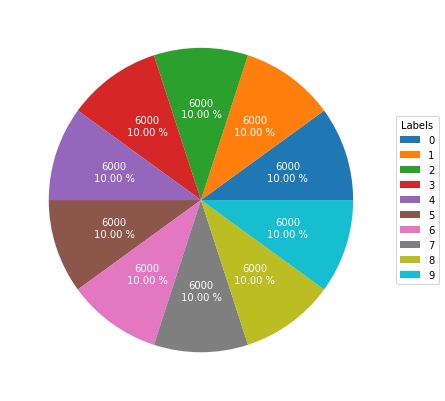

In [4]:
dat = Create_Array(train, 1, 123)
_ = dat.get_pie_chart(figsize=(10,7))

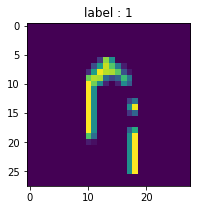

In [5]:
_ = dat.show_one_image(figsize=(3,3))

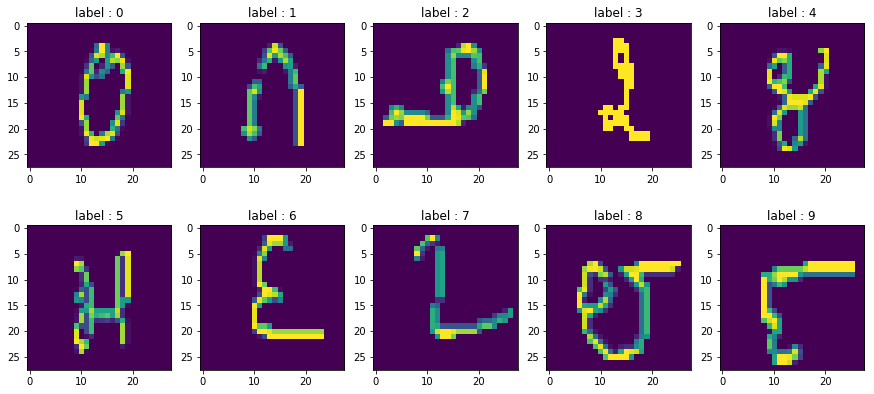

In [6]:
dat.show_multiple_images(figsize=(15,18), seed=93, show_plot=True)

In [7]:
# split the dataset
dat.split_data(test_size=0.15, to_category=False)

In [8]:
print("dimension of train : {}".format(dat.train_X.shape))
print("dimension of test : {}".format(dat.test_X.shape))

dimension of train : (51000, 28, 28, 1)
dimension of test : (9000, 28, 28, 1)


# Create model of cnn

In [9]:
# History plot
def history_plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()
    plt.grid(True)
    
    #plt.figure()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.grid(True)
    
    #plt.show()
    return plt

In [10]:
# Confusion matrix
def get_confusion_matrix(Y, y_pred, figsize=(7,7), dpi=90, normalize=False, cmap=plt.cm.Blues):
        cnf_matrix = confusion_matrix(Y, y_pred)
        acc = metrics.accuracy_score(Y, y_pred)
        
        if normalize:
            cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')
        
        plt.figure(figsize=figsize, dpi=dpi)
        plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
        title = 'Confusion matrix\nAccuracy : {} %'.format(np.round(100*acc,2))
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(10)
        xtick = [t for t in range(10)]
        plt.xticks(tick_marks, xtick, rotation=0)
        plt.yticks(tick_marks, xtick)
        
        fmt = '.2f' if normalize else 'd'
        thresh = cnf_matrix.max() / 2.
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, format(cnf_matrix[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cnf_matrix[i, j] > thresh else "black")
        
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        return plt

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
# Creating a Sequential Model and adding the layers
model = Sequential()

model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

In [27]:
# Reshaping the array to 4-dims so that it can work with the Keras API
#x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
#x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train = dat.train_X
x_test = dat.test_X
y_train = dat.train_y
y_test = dat.test_y
input_shape = (1, 28, 28)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255

In [30]:
# fit the cnn model
def fit_model(model, epoch):
    model.compile(optimizer="adam",
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,
                        nb_epoch=epoch,
                        validation_data=(x_test, y_test),
                        verbose=1)
    return model, history

In [31]:
model, history = fit_model(model=model, epoch=100)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # Remove the CWD from sys.path while we load stuff.


Train on 51000 samples, validate on 9000 samples
Epoch 1/100
51000/51000 [==============================] - 37s 724us/step - loss: 0.2434 - acc: 0.9244 - val_loss: 0.0470 - val_acc: 0.9863
Epoch 2/100
51000/51000 [==============================] - 32s 629us/step - loss: 0.0589 - acc: 0.9831 - val_loss: 0.0278 - val_acc: 0.9920
Epoch 3/100
51000/51000 [==============================] - 32s 632us/step - loss: 0.0494 - acc: 0.9866 - val_loss: 0.0567 - val_acc: 0.9837
Epoch 4/100
51000/51000 [==============================] - 32s 632us/step - loss: 0.0406 - acc: 0.9886 - val_loss: 0.0260 - val_acc: 0.9922
Epoch 5/100
51000/51000 [==============================] - 33s 645us/step - loss: 0.0354 - acc: 0.9904 - val_loss: 0.0179 - val_acc: 0.9954
Epoch 6/100
51000/51000 [==============================] - 32s 630us/step - loss: 0.0318 - acc: 0.9909 - val_loss: 0.0270 - val_acc: 0.9919
Epoch 7/100
51000/51000 [==============================] - 32s 632us/step - loss: 0.0278 - acc: 0.9923 - val_lo

51000/51000 [==============================] - 33s 638us/step - loss: 0.0039 - acc: 0.9989 - val_loss: 0.0177 - val_acc: 0.9966
Epoch 59/100
51000/51000 [==============================] - 32s 636us/step - loss: 0.0022 - acc: 0.9994 - val_loss: 0.0217 - val_acc: 0.9961
Epoch 60/100
51000/51000 [==============================] - 32s 636us/step - loss: 0.0036 - acc: 0.9990 - val_loss: 0.0249 - val_acc: 0.9958
Epoch 61/100
51000/51000 [==============================] - 32s 636us/step - loss: 0.0028 - acc: 0.9993 - val_loss: 0.0220 - val_acc: 0.9958
Epoch 62/100
51000/51000 [==============================] - 33s 637us/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.0230 - val_acc: 0.9960
Epoch 63/100
51000/51000 [==============================] - 33s 640us/step - loss: 0.0022 - acc: 0.9995 - val_loss: 0.0228 - val_acc: 0.9961
Epoch 64/100
51000/51000 [==============================] - 33s 637us/step - loss: 0.0031 - acc: 0.9993 - val_loss: 0.0230 - val_acc: 0.9954
Epoch 65/100
51000/51000 [

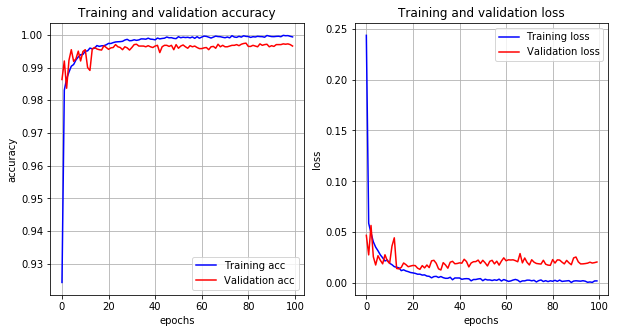

In [32]:
_ = history_plot(history)

In [33]:
print("evaluation in train : ")
eval_train = model.evaluate(x_train, y_train)
print(eval_train)
print("evaluation in test : ")
eval_test = model.evaluate(x_test, y_test)
print(eval_test)

evaluation in train : 
51000/51000 [==============================] - 9s 171us/step
[0.00012718229970104243, 0.9999607843137255]
evaluation in test : 
9000/9000 [==============================] - 1s 164us/step
[0.0208079473503951, 0.9965555555555555]


Confusion matrix, without normalization


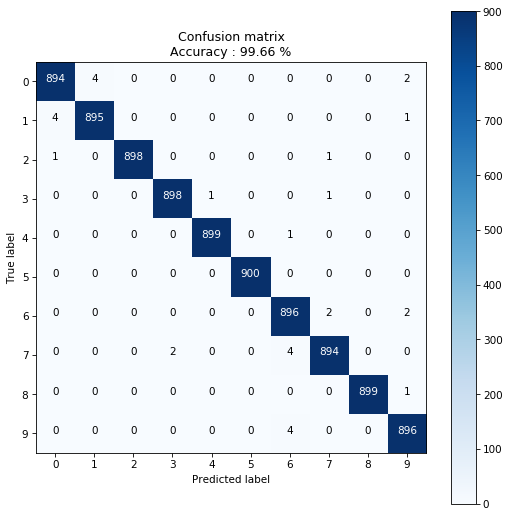

In [34]:
# Confusion matrix in test
predicted_test = model.predict_classes(x_test)
_ = get_confusion_matrix(Y=y_test, y_pred=predicted_test, normalize=False, dpi=75, figsize=(7,7))

In [35]:
def show_multiple_images_predicted(num_dict, model, figsize):
    label_predicted = dict()
    for lab_ref,img in num_dict.items():
        lab_pred = model.predict_classes(img.reshape(1, 28, 28).reshape(1, 28, 28, 1))[0]
        label_predicted[lab_ref] = lab_pred
    fig = plt.figure(figsize=figsize)
    for l_ref,l_pred in label_predicted.items():
        ax = fig.add_subplot(5, 5, 1 + l_ref)
        ax.imshow(num_dict[l_ref])
        ax.title.set_text("label : {}\npredicted : {}".format(l_ref,l_pred))

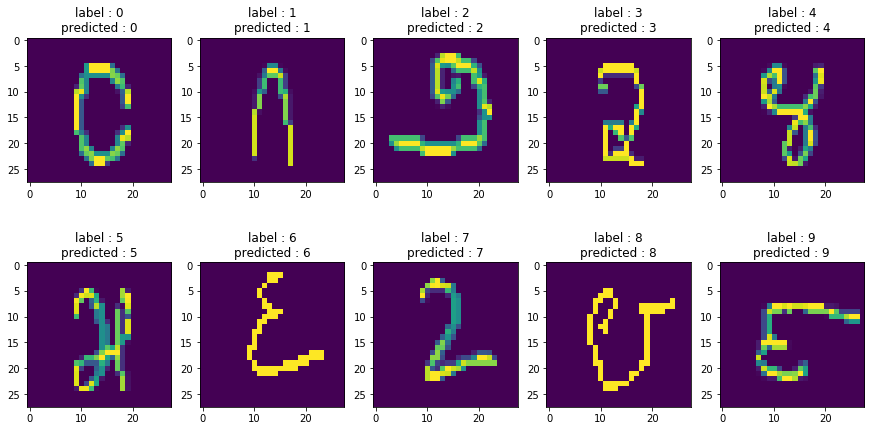

In [36]:
dat.show_multiple_images(figsize=(15,18), seed=1265439, show_plot=False)
show_multiple_images_predicted(dat.num_dict, model, (15,20))

Confusion matrix, without normalization


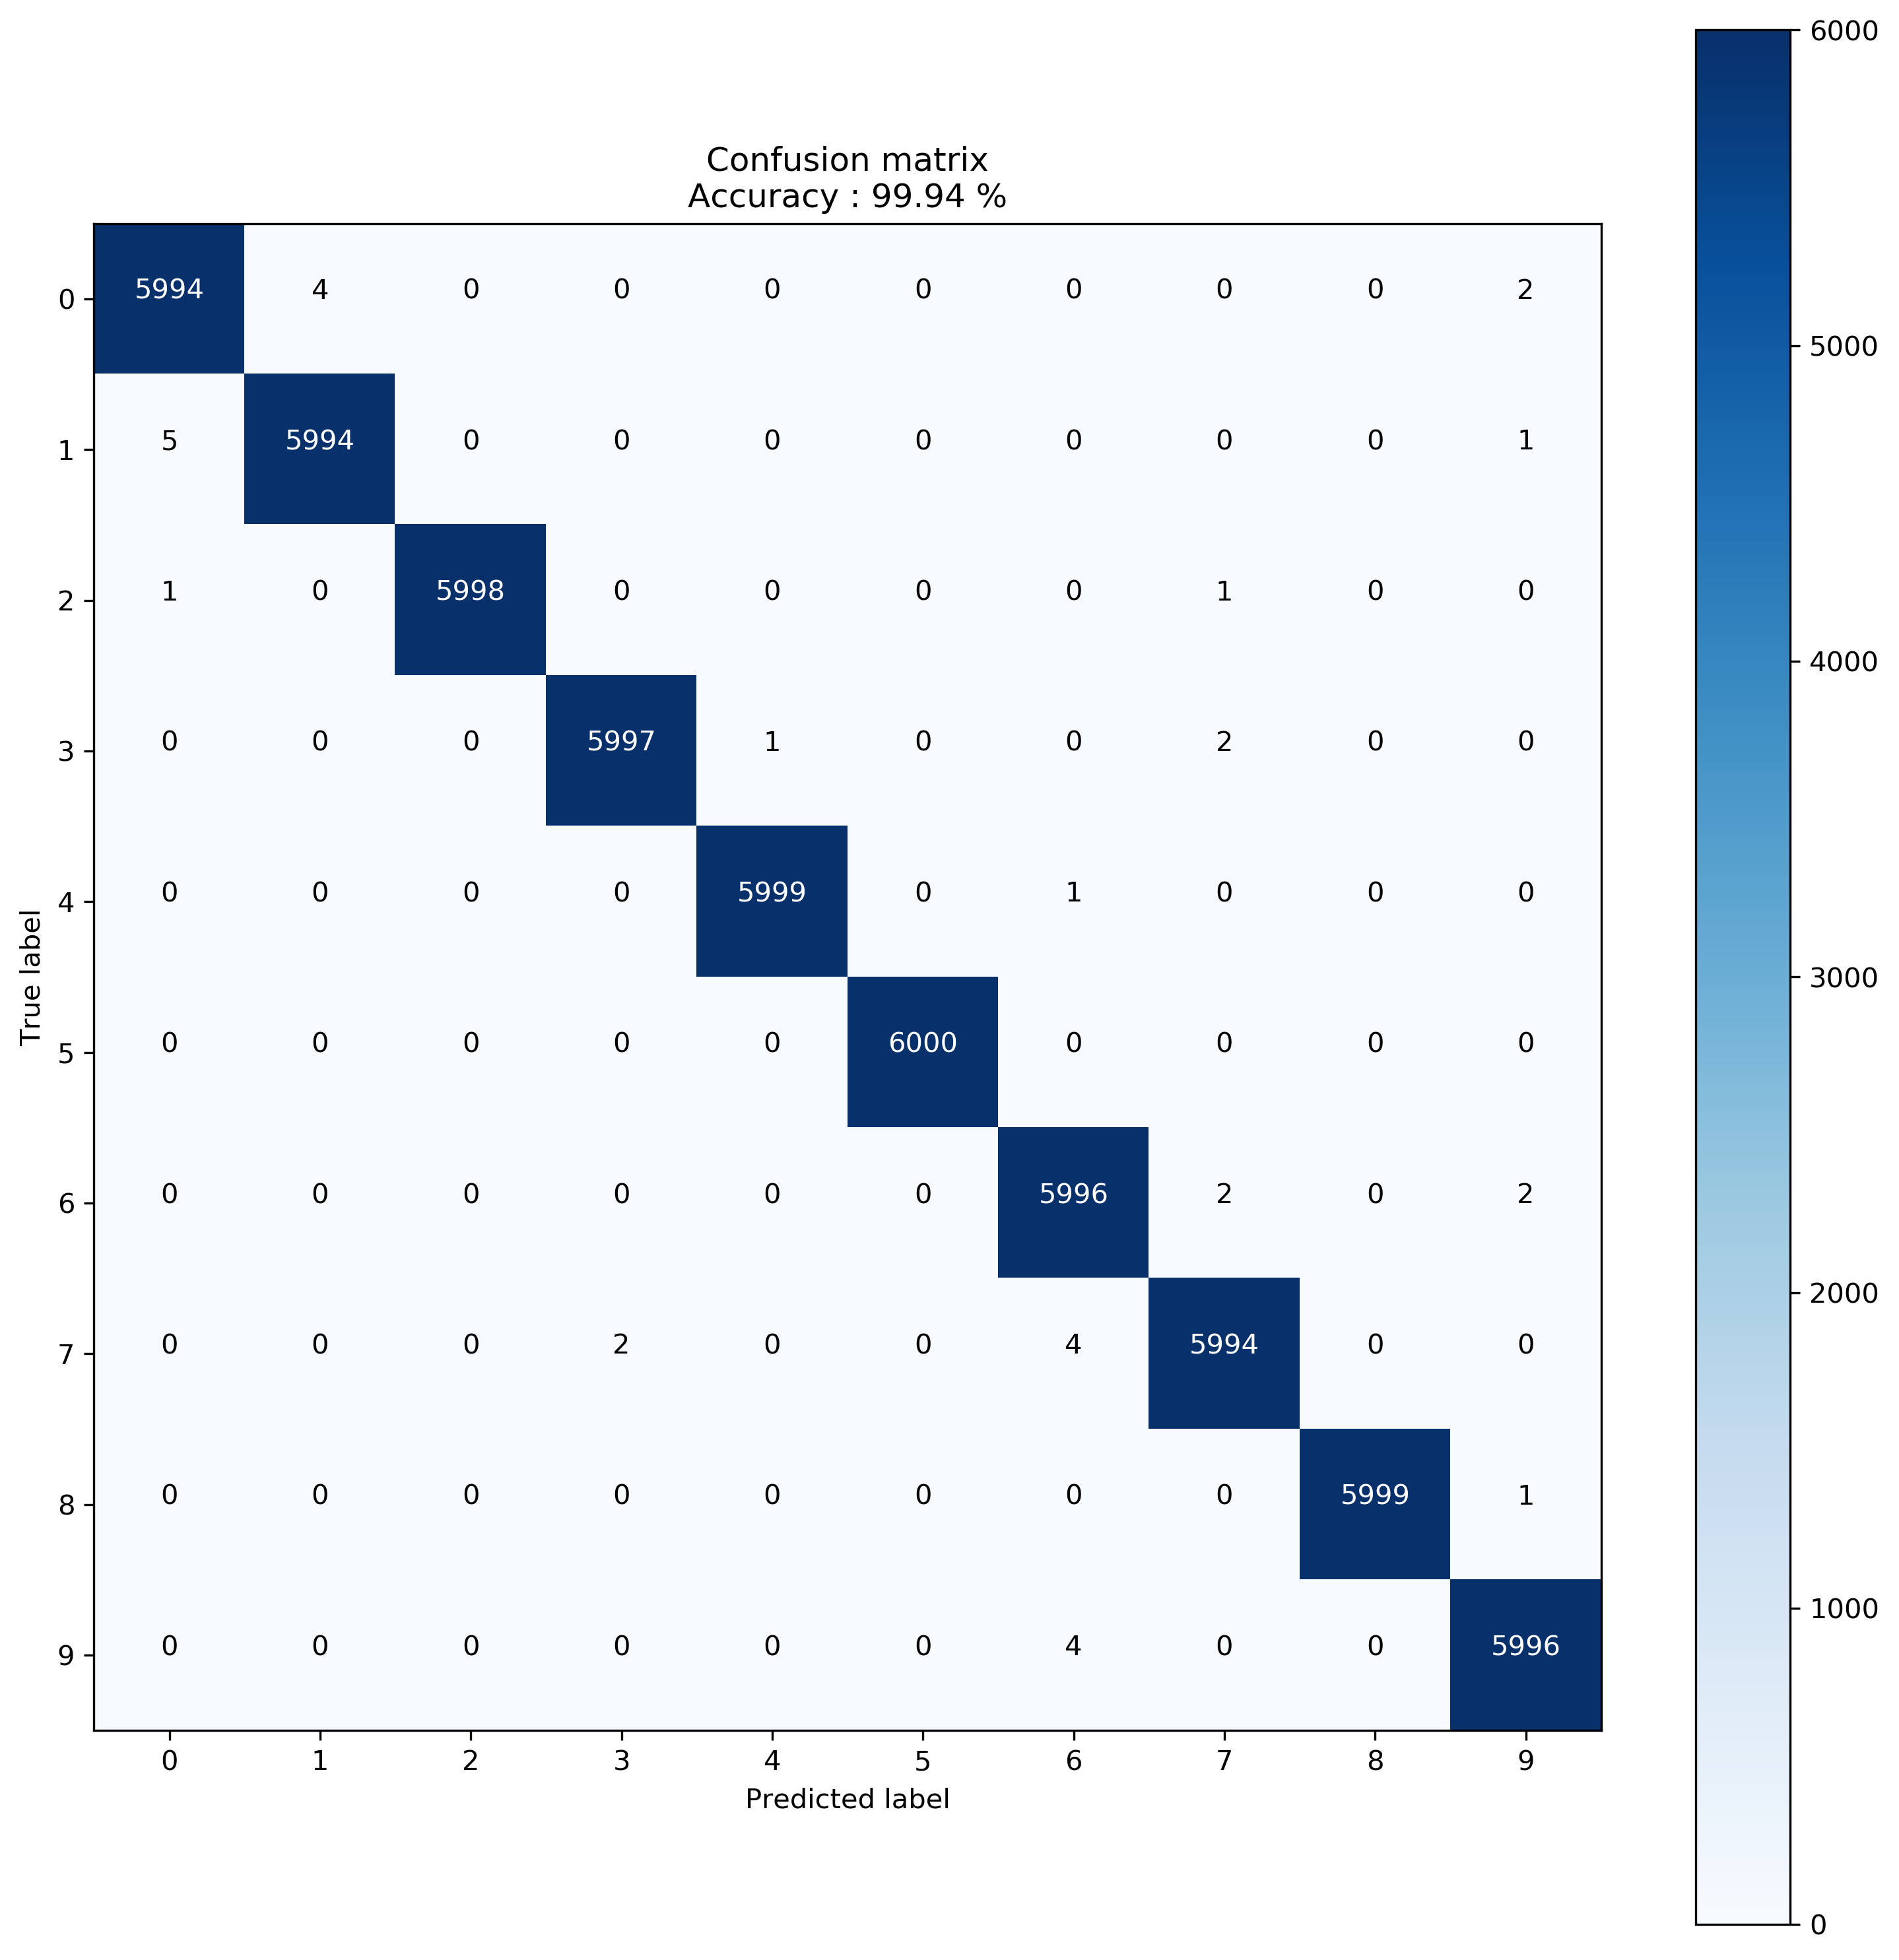

In [45]:
# Confusion matrix in whole dataset
x_dataset = dat.data.drop(columns=["label"])
y_dataset = dat.data.label
input_shape = (1, 28, 28)

# Making sure that the values are float so that we can get decimal points after division
x_dataset = x_dataset.astype('float32')

# Normalizing the RGB codes by dividing it to the max RGB value.
x_dataset /= 255

label_pred = model.predict_classes(x_dataset.values.reshape(x_dataset.shape[0], 28, 28).reshape(x_dataset.shape[0], 28, 28, 1))

_ = get_confusion_matrix(Y=y_dataset, y_pred=label_pred, normalize=False, dpi=300, figsize=(10,10)).savefig("../confusion_matrix.jpg")

# Prediction on the test set

In [38]:
test_to_predict = test.drop(columns=['id'])
test_to_predict = test_to_predict.astype('float32')
test_to_predict /= 255

label_predicted = \
model.predict_classes(test_to_predict.values.reshape(test_to_predict.shape[0], 28, 28).reshape(test_to_predict.shape[0], 28, 28, 1))

test_predicted = test.copy()
test_predicted['label'] = label_predicted

submission = test_predicted[["id", "label"]]

In [39]:
submission.to_csv("submission.csv", index=False)

In [40]:
submission.groupby(['label'])['label'].count()

label
0    487
1    527
2    503
3    474
4    511
5    491
6    501
7    505
8    483
9    518
Name: label, dtype: int64

In [41]:
def show_images_on_test(data, seed, figsize):
    random.seed(seed)
    ind = random.sample(k=10, population=set(data.id))
    img = data.drop(columns=['id','label'])
    label = data['label']
    id_img = data['id']
    fig = plt.figure(figsize=figsize)
    for k in range(len(ind)):
        ax = fig.add_subplot(5, 5, 1 + k)
        img_k = img.loc[ind[k]].values.reshape(28,28)
        ax.imshow(img_k)
        ax.title.set_text("label : {}\nid : {}".format(label[ind[k]],id_img[ind[k]]))
    return plt

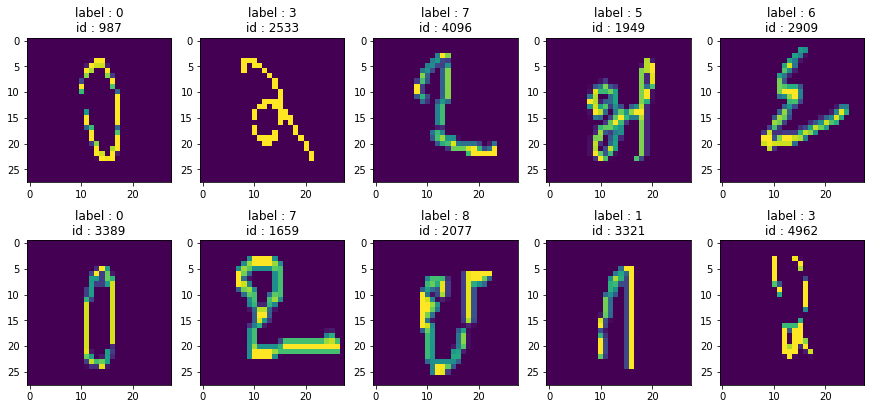

In [42]:
_ = show_images_on_test(test_predicted, 99999, (15,18))